# YOLO Inference On Taco Images

- TACO: (Trash Annotations in Context)

* A model must be trained.
    - Be located in the ./checkpoints dir.
    - And its filename must be in config.yaml, ex: "yolo_v1_taco_D_2025-07-08_EPOCH_50_LOSS_2.1525_S_448.pt".
* Run Yolo model on custom images.


In [19]:
import torch
import torchvision.transforms as T
from argparse import Namespace
import torch.optim as optim
from utils.checkpoints import load_checkpoint
from yolov1 import YOLOv1
torch.set_printoptions(threshold=torch.inf) # When printing tensors, should all values, only use in Jupyter Notebook.
torch.manual_seed(1)

In [20]:
# For Jupyter Notebook: reloads external functions when its code changes.
%load_ext autoreload
%autoreload 1 
# 0: Disables automatic reloading (default setting). 1: Reloads only modules imported using the %aimport magic command. 2: Reloads all modules (except those explicitly excluded by %aimport)

# %aimport module name will only reload those files

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Add Configurations

In [21]:
%aimport utils.load_config
from utils.load_config import load_config

config = load_config()
config

Namespace(DEVICE=device(type='mps'), NUM_WORKERS=2, PIN_MEMORY=True, EPOCHS=25, LEARNING_RATE=0.001, BATCH_SIZE=64, WEIGHT_DECAY=0, CON_TRAINING=False, LOAD_MODEL_FILE='yolo_v1_taco_D_2025-07-11_EPOCH_25_LOSS_7642.7793_SIZE_448.pt', LAST_EPOCH=0, WHICH_DATASET='test-case-overfit-one-image', IMAGE_SIZE=448, C=18, B=2, S=7, IOU_THRESHOLD=0.6, MIN_THRESHOLD=0.5, NUM_NODES_PER_CELL=28, NUM_NODES_PER_IMG=1372)

### Add Transforms

In [22]:
# <------------- Transforms ------------->
class Compose(object):
    """Apply a sequence of transforms safely on (image, bboxes)."""

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img, bboxes)
        return img, bboxes


class Resize(object):
    """Resize the image. No change needed for bboxes since they are normalized (0-1)."""

    def __init__(self, size):
        self.size = size  # (width, height) like (448,448)

    def __call__(self, img, bboxes):
        img = T.Resize(self.size)(img)
        return img, bboxes  # bboxes stay the same


class ToTensor(object):
    """Convert image to Tensor. Leave bboxes as they are."""

    def __call__(self, img, bboxes):
        img = T.ToTensor()(img)  # Automatically normalize image between 0-1
        return img, bboxes


transforms = Compose(
    # transform object to resize the bboxes and images.  Normalize image tensors
    [
        Resize((448, 448)),  # Resize image to 448x448
        ToTensor(),  # Convert image to tensor
    ]
)

### Load Model

In [23]:
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR

yolo = YOLOv1(in_channels=3, S=config.S, B=config.B, C=config.C).to(config.DEVICE)

optimizer = optim.Adam(
    yolo.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY
)

# ==> Init Learning rate scheduler with a warm-up
warm_up = LinearLR(  # warmups help prevent exploding gradients early on.
    optimizer=optimizer, start_factor=0.1, total_iters=5
)  # 10% of LR over first 5 epochs, then back to regular LR.

cosine = CosineAnnealingLR(optimizer, T_max=config.EPOCHS - 5)

scheduler = SequentialLR(
    optimizer,
    schedulers=[warm_up, cosine],
    milestones=[5],  # switch from warm_up to cosine after epoch 5
)

# ==> Load A model.
load_checkpoint(
            file_name=config.LOAD_MODEL_FILE,
            yolo=yolo,
            optimizer=optimizer,
            scheduler=scheduler,
        )


################################################################ 

Loading Model | model_name: yolo_v1_taco_D_2025-07-11_EPOCH_25_LOSS_7642.7793_SIZE_448.pt

 Saved Model Attributes:
  epoch      → 25
  model      → dict with 148 entries
  optimizer  → dict with 2 entries
  mean_loss  → 7642.779296875

√ Loaded model.

################################################################ 



25

### Load Dataset

In [24]:
from yolov1.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

# config.MODE = "test"
dataset = Dataset(S=config.S, B=config.B, C=config.C, whichDataset=config.WHICH_DATASET, transforms=transforms)
"# of images:",dataset.__len__()

Checking csv dataframe file: csv dataframe file already exists.


('# of images:', 1)

In [25]:
img_t, label_t = dataset.__getitem__(0) # Load the image at index __(int) from the dataframe csv. Depending on the config.MODE, the dataframe will either be train.csv, valid.csv or test.csv
img_t.shape, label_t.shape

(torch.Size([3, 448, 448]), torch.Size([7, 7, 28]))

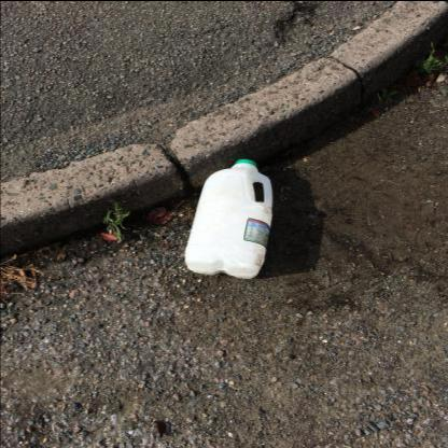

In [26]:
img = to_pil_image(img_t)
img

### Predict

In [27]:
# Add a batch to the img tensor, so that it can be feed to the model. Yolo model expects shape (BATCH_SIZE, img_channel_size, Img_Size, Img_Size).
img_t = img_t.unsqueeze(0)
img_t.shape

torch.Size([1, 3, 448, 448])

In [28]:
out = yolo(img_t.to(config.DEVICE))
out, out.shape

(tensor([[[[ 2.3676e+00, -5.1044e+00, -1.6109e+01,  2.4046e+00,  5.6550e-01,
            -4.3241e+00, -1.3976e+01,  1.4230e+01,  2.3716e+00,  8.9494e+00,
            -1.3230e+01,  7.8848e+00,  5.1515e+00,  7.3833e+00, -7.7512e+00,
            -1.7115e+01,  1.1773e+01,  1.0636e+01,  3.4340e-19,  1.0000e+00,
             9.9997e-01,  9.9999e-01,  1.0000e+00,  1.1561e-21,  9.5597e-01,
             3.2857e-05,  2.3530e-04,  4.0622e-06],
           [ 7.1281e-01,  1.4590e+00,  5.8914e+00,  1.5395e+01,  2.5454e+00,
            -8.1482e+00, -1.4543e+01,  1.4759e+01,  2.3624e-01, -5.4414e+00,
             8.1068e+00,  3.9920e+00,  1.2736e+01, -7.7716e+00, -4.8169e+00,
            -4.4818e+00, -8.8614e+00, -3.0721e+00,  1.0050e-15,  7.7762e-05,
             1.8699e-02,  9.9978e-01,  9.9972e-01,  2.2238e-25,  1.2623e-04,
             6.5444e-01,  1.0000e+00,  9.9990e-01],
           [ 2.5892e-02, -5.3127e+00,  5.8702e+00,  9.5111e+00, -1.4836e+01,
             4.7054e+00,  1.2825e+01, -2.4343e+00

### Reshape Output
* Reshape output from (1, 1372) -> (1, 7, 7, 28) ->  (7, 7, 28) 
    - Remove the batch because we are only working with one image. 

In [29]:
# Reshape output
out = out.view(1, 7, 7, 28)
out = out.squeeze()
out.shape

torch.Size([7, 7, 28])

### Extract Bounding Boxes

In [30]:
%aimport utils.bboxes

from utils.bboxes import extract_bboxes, reconstruct_tensor

pred_bboxes = extract_bboxes(out, config) # (N, 9) [ i, j, b, class_idx, pc, x, y, w, h]
pred_bboxes.shape

torch.Size([98, 9])

### Compute Non-Max-Suppression
* Remove redundant bounding boxes from the models prediction.

In [31]:
%aimport utils.nms

from utils.nms import non_max_suppression

In [32]:
nms_bboxes = non_max_suppression(
    pred_bboxes=pred_bboxes,
    config=config
)

# The bboxes from the models prediction that survived NMS.
nms_bboxes.shape 

torch.Size([1, 9])

### Plot The Predicted And True Bounding Boxes

In [33]:
%aimport utils.plot
from utils.plot import plot_bboxes

In [34]:
label_t = label_t.to(config.DEVICE)
label_bboxes = extract_bboxes(label_t, config)

In [35]:
label_filter = label_bboxes[label_bboxes[:, 4] == 1]
label_filter, label_filter.shape # The bboxes from the label where an object is.

(tensor([[2.0000, 3.0000, 0.0000, 2.0000, 1.0000, 0.8281, 0.5409, 0.0529, 0.0192],
         [3.0000, 3.0000, 0.0000, 1.0000, 1.0000, 0.5757, 0.3990, 0.1971, 0.2668]],
        device='mps:0'),
 torch.Size([2, 9]))

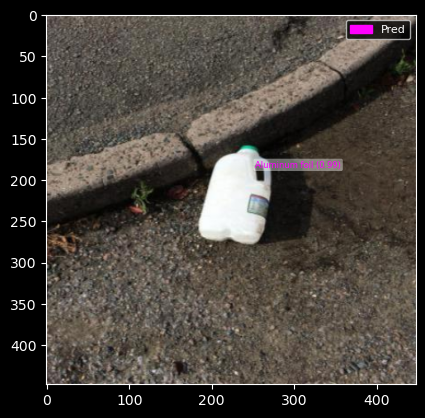

In [36]:
plot_bboxes(img=img, label_bboxes=None, pred_bboxes=nms_bboxes, S=config.S)

### Upload Image